In [0]:
# Default mount-path: /content/drive/Shared drives/Probstat

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
root_path = './gdrive/Shared drives/Probstat'

## SF Covid-19 Dataset

In [0]:
cases_df = pd.read_csv(root_path + '/data/COVID-19_Cases_Summarized_by_Date__Transmission_and_Case_Disposition.csv')

In [0]:
cases_df.isna().sum()

Date                     0
Transmission Category    0
Case Disposition         0
Case Count               0
dtype: int64

#### We can verify in above query, 0 MISSING values were found 

## Pre-processing steps for SF Covid-19 Dataset

1.   Converting Date column into date-time dtype



In [0]:
cases_df["Date"] = pd.to_datetime(cases_df["Date"], format="%Y/%m/%d")

In [0]:
# Verify by uncommenting and toggling with ascending=True/False
# cases_df.sort_values(by="Date", ascending=False)

## Crime Dataset

In [0]:
crime_df = pd.read_csv(root_path + '/data/Police_Department_Incident_Reports__2018_to_Present.csv')

In [0]:
crime_df.shape

(342936, 36)

In [0]:
crime_df.isna().sum()

Incident Datetime                                            0
Incident Date                                                0
Incident Time                                                0
Incident Year                                                0
Incident Day of Week                                         0
Report Datetime                                              0
Row ID                                                       0
Incident ID                                                  0
Incident Number                                              0
CAD Number                                               79225
Report Type Code                                             0
Report Type Description                                      0
Filed Online                                            269212
Incident Code                                                0
Incident Category                                          162
Incident Subcategory                                   

## Pre-processing steps for Crime Dataset:


### Considering only non-null columns and Incident columns

In [0]:
columns_to_consider = ["Incident Datetime", "Incident Date", "Incident Time", "Incident Year", "Incident Day of Week", "Report Datetime", "Row ID", "Incident ID", "Incident Number", "Report Type Code", "Report Type Description", "Incident Code", "Incident Category", "Incident Subcategory", "Incident Description", "Resolution", "Police District"]

In [0]:
crime_df = crime_df[columns_to_consider]

In [0]:
crime_df = crime_df[crime_df["Incident Category"].notna()]

In [0]:
# Verify whhether nulls are removed through the above query
crime_df.isnull().sum()

Incident Datetime          0
Incident Date              0
Incident Time              0
Incident Year              0
Incident Day of Week       0
Report Datetime            0
Row ID                     0
Incident ID                0
Incident Number            0
Report Type Code           0
Report Type Description    0
Incident Code              0
Incident Category          0
Incident Subcategory       0
Incident Description       0
Resolution                 0
Police District            0
dtype: int64

In [0]:
crime_df["Incident Date"] = pd.to_datetime(crime_df["Incident Date"], format="%Y/%m/%d")

In [0]:
crime_df["Incident Datetime"] = pd.to_datetime(crime_df["Incident Datetime"], format="%Y/%m/%d %I:%M:%S %p")

In [0]:
crime_df.dtypes

Incident Datetime          datetime64[ns]
Incident Date              datetime64[ns]
Incident Time                      object
Incident Year                       int64
Incident Day of Week               object
Report Datetime                    object
Row ID                              int64
Incident ID                         int64
Incident Number                     int64
Report Type Code                   object
Report Type Description            object
Incident Code                       int64
Incident Category                  object
Incident Subcategory               object
Incident Description               object
Resolution                         object
Police District                    object
dtype: object

## Visualizations

In [0]:
crime_df.head(1)

,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,Report Type Code,Report Type Description,Incident Code,Incident Category,Incident Subcategory,Incident Description,Resolution,Police District
0,2020-02-03 14:45:00,2020-02-03,14:45,2020,Monday,2020/02/03 05:50:00 PM,89881675000,898816,200085557,II,Initial,75000,Missing Person,Missing Person,Found Person,Open or Active,Taraval


In [0]:
def convert_agg_df_into_flatten_df(df):
  df = df.reset_index()
  df.columns = [' '.join(col).strip() for col in df.columns.values]

  return df

# df = crime_df.groupby(['Incident Date'])['Incident Date'].agg(["count"]).reset_index()
# df.head()

#### Unique first Reports below are basically unique crimes that have been occured (we filtered according to the below criterias because we want to avoid counting same crime twice with other report types i.e. supplemental reports)

In [0]:
unique_first_reports = crime_df[(crime_df["Report Type Description"] == 'Initial') |
                         (crime_df["Report Type Description"] == 'Initial Supplement') | 
                         (crime_df["Report Type Description"] == 'Vehicle Initial') |
                         (crime_df["Report Type Description"] == 'Coplogic Initial')]

unique_first_reports["Report Type Description"].value_counts()

Initial               213832
Coplogic Initial       65508
Initial Supplement     27882
Vehicle Initial        16277
Name: Report Type Description, dtype: int64

In [0]:
df = unique_first_reports['Incident Date'].value_counts().to_frame().reset_index()
df = df.rename(columns={"index": "date", "Incident Date": "count"})
df = df.sort_values(by=["date"])
df.head()

,date,count
14,2018-01-01,478
453,2018-01-02,380
265,2018-01-03,405
107,2018-01-04,433
156,2018-01-05,424


## Un-Smoothened and Smoothened crime cases by day


1.   For smoothening purposes used Simple Moving Average spanning over a week


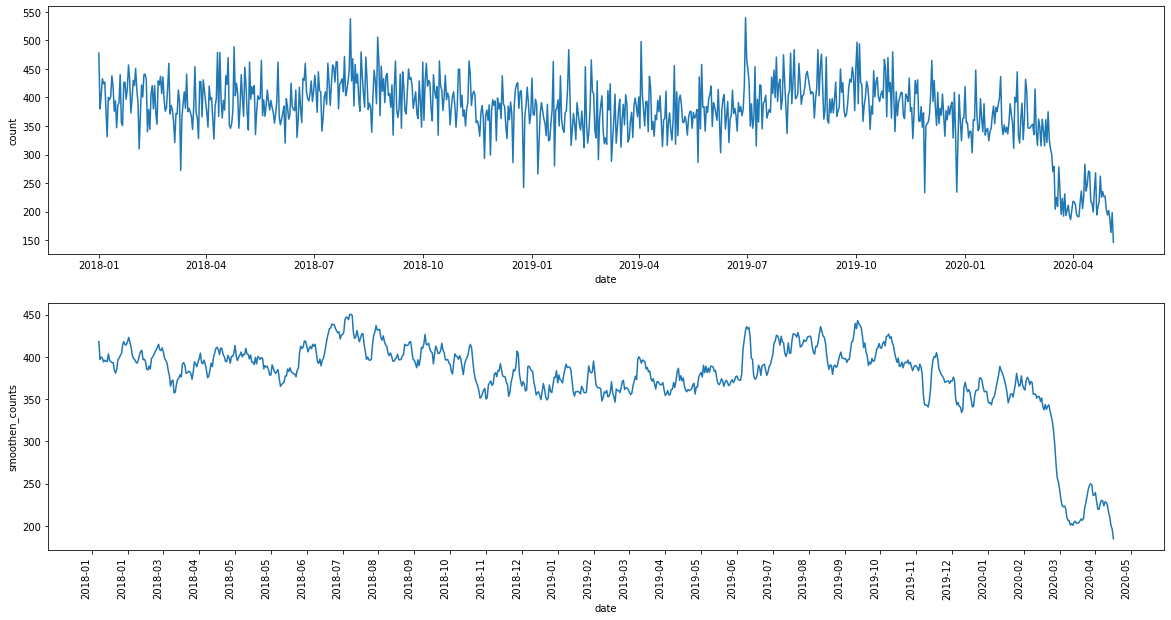

In [0]:
figure, axes = plt.subplots(figsize=(20, 10), nrows=2, ncols=1)
sns.lineplot(x='date', y='count', data=df, ax=axes[0])


df['smoothen_counts'] = df['count'].rolling(window=7).mean()
df.head(10)

g = sns.lineplot(x='date', y='smoothen_counts', data=df, ax=axes[1])

base_date = datetime.datetime.strptime('2018-01-01', '%Y-%m-%d')
dates = [base_date + datetime.timedelta(days=i * 30) for i in range(30)]
xfmt = mdates.DateFormatter('%Y-%m')
axes[1].xaxis.set_major_formatter(xfmt)
axes[1].set_xticks(dates)

x_dates = [date.strftime("%Y-%m") for date in dates]
remnant = axes[1].set_xticklabels(labels=x_dates, rotation=90, ha='right')

### As we can see there's huge drop after first week of March 2020.
#### Because the first case of corona in San-Francisco was observed in 5th March, after which social-distancing measures were implemented

In [0]:
vehicle_unique_reports = unique_first_reports[(unique_first_reports["Report Type Description"] == "Vehicle Initial")]
vehicle_stats = vehicle_unique_reports["Incident Date"].value_counts().to_frame().reset_index()
vehicle_stats = vehicle_stats.rename(columns={"index": "date", "Incident Date": "count"})
vehicle_stats = vehicle_stats.sort_values(by="date")

vehicle_stats['smoothen_counts'] = vehicle_stats['count'].rolling(window=7).mean()

online_unique_reports = unique_first_reports[(unique_first_reports["Report Type Description"] == "Coplogic Initial")]
online_stats = online_unique_reports["Incident Date"].value_counts().to_frame().reset_index()
online_stats = online_stats.rename(columns={"index": "date", "Incident Date": "count"})
online_stats = online_stats.sort_values(by="date")

online_stats['smoothen_counts'] = online_stats['count'].rolling(window=7).mean()

In [0]:
vehicle_stats

,date,count,smoothen_counts
286,2018-01-01,21,NaN
228,2018-01-02,22,NaN
258,2018-01-03,21,NaN
500,2018-01-04,18,NaN
85,2018-01-05,26,NaN
...,...,...,...
141,2020-05-01,24,19.571429
725,2020-05-02,14,18.857143
426,2020-05-03,19,18.428571
439,2020-05-04,18,18.285714


In [0]:
vehicle_online_unique_reports = unique_first_reports[(unique_first_reports["Report Type Description"] == "Vehicle Initial") |
                                                     (unique_first_reports["Report Type Description"] == "Coplogic Initial")]

In [0]:
df = vehicle_online_unique_reports.groupby(["Incident Date", "Report Type Description"]).agg({'Incident Date': ['count']})
df = convert_agg_df_into_flatten_df(df)
df = df.rename(columns={"Incident Date count": "count", "Incident Date": "date"})

In [0]:
df.head()

,date,Report Type Description,count
0,2018-01-01,Coplogic Initial,104
1,2018-01-01,Vehicle Initial,21
2,2018-01-02,Coplogic Initial,73
3,2018-01-02,Vehicle Initial,22
4,2018-01-03,Coplogic Initial,105


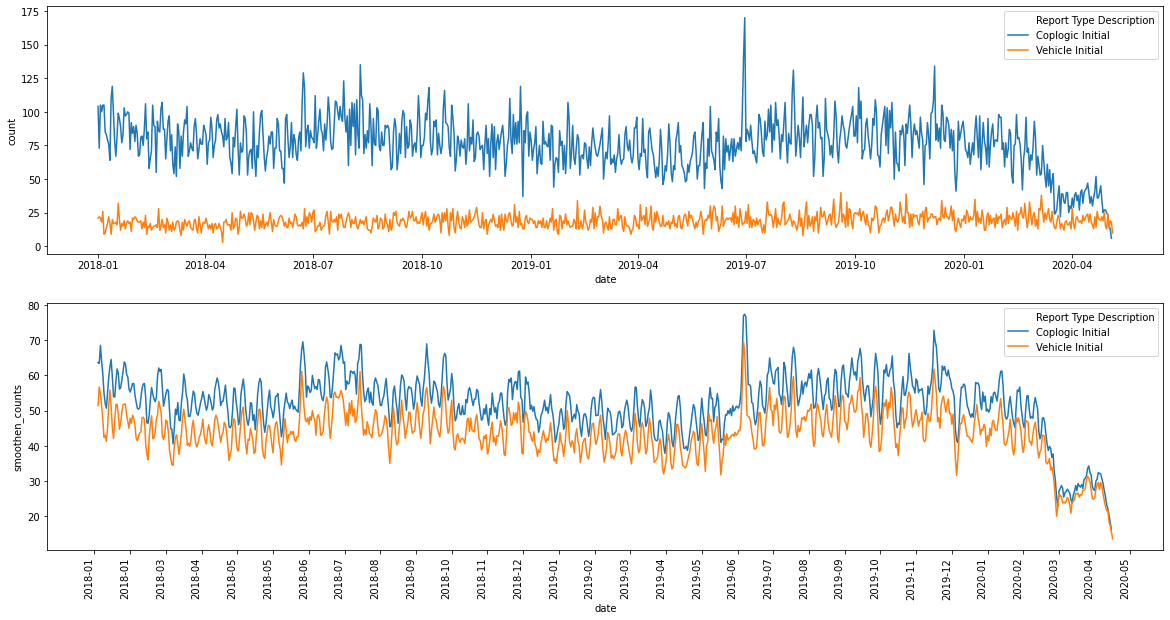

In [0]:
figure, axes = plt.subplots(figsize=(20, 10), nrows=2, ncols=1)
sns.lineplot(x='date', y='count', hue="Report Type Description", data=df, ax=axes[0])


df['smoothen_counts'] = df['count'].rolling(window=7).mean()
df.head(10)

g = sns.lineplot(x='date', y='smoothen_counts', hue="Report Type Description", data=df, ax=axes[1])

base_date = datetime.datetime.strptime('2018-01-01', '%Y-%m-%d')
dates = [base_date + datetime.timedelta(days=i * 30) for i in range(30)]
xfmt = mdates.DateFormatter('%Y-%m')
axes[1].xaxis.set_major_formatter(xfmt)
axes[1].set_xticks(dates)

x_dates = [date.strftime("%Y-%m") for date in dates]
remnant = axes[1].set_xticklabels(labels=x_dates, rotation=90, ha='right')

In [49]:
# 1st required inference - Time series analysis for COVID19 data - AR(3), AR(5), EWMA(0.5), EWMA(0.8) - For fatalities and number of cases

# Group the data by Case Disposition(Death, New Case) and Date
cases_df_grouped = cases_df.groupby(by=['Case Disposition', 'Date'])

# Search for the start date and end date in the data
start_date = cases_df['Date'].min()
end_date = cases_df['Date'].max()

# Calculate the total number of days based on start date and end date
num_of_days = end_date - start_date
num_of_days = num_of_days.days + 1

# Prepare a list of number of cases and deaths where index = index of the day from start date
num_cases_list = [ 0 for i in range(num_of_days)]
deaths_list = [0 for i in range(num_of_days)]

# Iterate through the groups of data to extract number of cases and fatalities 
# to store in a list
for name, group in cases_df_grouped:
  if name[0] == 'Confirmed':
    num_cases_list[(group['Date'].min() - start_date).days] = group['Case Count'].sum()
  else:
    deaths_list[(group['Date'].min()- start_date).days] = group['Case Count'].sum()


# Function to predict Auto Regression (AR) prediction values
def predict_ar(AR_p, day_of_the_week):

  training_data_count = num_of_days - 7 - AR_p + day_of_the_week + 1

  x_num_cases = [[0 for i in range(AR_p+1)] for i in range(training_data_count)]
  y_num_cases = [ 0 for i in range(training_data_count) ]

  x_deaths = [[0 for i in range(AR_p+1)] for i in range(training_data_count)]
  y_deaths = [ 0 for i in range(training_data_count) ]
  for i in range(training_data_count):
    x_num_cases[i][0] = 1
    y_num_cases[i] = num_cases_list[i+AR_p]

    x_deaths[i][0] = 1
    y_deaths[i] = deaths_list[i+AR_p]

    for j in range(AR_p):
      x_num_cases[i][AR_p - j] = num_cases_list[i+j]
      x_deaths[i][AR_p - j] = deaths_list[i+j]

  x_num_cases = np.array(x_num_cases)
  x_deaths = np.array(x_deaths)

  beta_num_cases = [0 for i in range(AR_p+1)]
  x_num_cases_transpose = np.matrix.transpose(x_num_cases)
  # Calculate the beta matrix for number of cases by the formula: beta = (inverse(X_transpose*X))*(X_transpose)*(Y)
  beta_num_cases = np.dot(np.dot(np.linalg.inv(np.dot(x_num_cases_transpose, x_num_cases)), x_num_cases_transpose), y_num_cases)

  beta_deaths = [0 for i in range(AR_p+1)]
  x_deaths_transpose = np.matrix.transpose(x_deaths)
  # Calculate the beta matrix for deaths by the formula: beta = (inverse(X_transpose*X))*(X_transpose)*(Y)
  beta_deaths = np.dot(np.dot(np.linalg.inv(np.dot(x_deaths_transpose, x_deaths)), x_deaths_transpose), y_deaths)

  # Calculate the predicted number of cases and deaths by the formula: Y = beta*X
  y_pred_num_cases = np.dot(x_num_cases, beta_num_cases)
  y_pred_deaths = np.dot(x_deaths, beta_deaths)

  return y_pred_num_cases[-1], y_pred_deaths[-1], y_num_cases[-1], y_deaths[-1]


# Function to predict the EWMA estimates 
def predict_ewma(alpha):

  y_pred_num_cases = [0 for i in range(len(num_cases_list))]
  y_pred_deaths = [0 for i in range(len(deaths_list))]

  # Calculate the initial predicted value as the actual value itself
  y_pred_num_cases[0] = num_cases_list[0]
  y_pred_deaths[0] = deaths_list[0]

  # For subsequent predictions, use the formula: alpha*(y_t) + (1-alpha)*(y_hat_t)
  for i in range(1,len(num_cases_list)):
    y_pred_num_cases[i] = round((alpha*num_cases_list[i-1] + (1-alpha)*y_pred_num_cases[i-1]), 2)
    y_pred_deaths[i] = round((alpha*deaths_list[i-1] + (1-alpha)*y_pred_deaths[i-1]), 2)

  return y_pred_num_cases[-7:], y_pred_deaths[-7:]

# Function to calculate MAPE and MSE values 
def calculate_mape_and_mse(y_pred_num_cases, y_num_cases, y_pred_deaths, y_deaths):
  mape_num_cases = 0
  mse_num_cases = 0

  mape_deaths = 0
  mse_deaths = 0
  for i in range(len(y_num_cases)):
    # Calculate MAPE for number of cases
    # Drop the cases when the actual value is zero
    if y_num_cases[i] != 0:
      mape_num_cases = mape_num_cases + (abs(y_num_cases[i] - y_pred_num_cases[i]))/y_num_cases[i]
    # Calculate MAPE for deaths
    # Drop the cases when the actual value is zero
    if y_deaths[i] != 0:
      mape_deaths = mape_deaths + (abs(y_deaths[i] - y_pred_deaths[i]))/y_deaths[i]
    # Calculate MSE for number of cases
    mse_num_cases = mse_num_cases + (y_num_cases[i] - y_pred_num_cases[i])*(y_num_cases[i] - y_pred_num_cases[i])
    # Calcuate MSE for deaths
    mse_deaths = mse_deaths + (y_deaths[i] - y_pred_deaths[i])*(y_deaths[i] - y_pred_deaths[i]) 
  mape_num_cases = (mape_num_cases*100)/len(y_num_cases)
  mape_deaths = (mape_deaths*100)/len(y_num_cases)
  mse_num_cases = mse_num_cases/len(y_num_cases)
  mse_deaths - mse_deaths/len(y_num_cases)

  mape_list = []
  mape_list.append(mape_num_cases)
  mape_list.append(mape_deaths)
  mse_list = []
  mse_list.append(mse_num_cases)
  mse_list.append(mse_deaths)

  return mape_list, mse_list


# Make empty lists to store the actual and predicted values for fatalities and number 
# of cases for last 1 week for AR(3), AR(5), EWMA(0.5), EWMA(0.8)
y_num_cases_7_days = []
y_deaths_7_days = []
y_pred_num_cases_7_days_ar_3 = []
y_pred_deaths_7_days_ar_3 = []
y_pred_num_cases_7_days_ar_5 = []
y_pred_deaths_7_days_ar_5 = []
y_pred_num_cases_ewma_5 = []
y_pred_deaths_ewma_5 = []
y_pred_num_cases_ewma_8 = []
y_pred_deaths_ewma_8 = []


# Call the functions to get the results 
for i in range(7):
  # Get the predictions for AR(3) for fatalities and number of cases for last 1 week
  results = predict_ar(3, i)
  y_pred_num_cases_7_days_ar_3.append(round(results[0],2))
  y_pred_deaths_7_days_ar_3.append(round(results[1],2))
  y_num_cases_7_days.append(results[2])
  y_deaths_7_days.append(results[3])

  # Get the predictions for AR(5) for fatalities and number of cases for last 1 week
  results_1 = predict_ar(5, i)
  y_pred_num_cases_7_days_ar_5.append(round(results_1[0],2))
  y_pred_deaths_7_days_ar_5.append(round(results_1[1],2))

# Get the predictions for EWMA(alpha=0.5) for fatalities and number of cases for last 1 week
y_pred_num_cases_ewma_5, y_pred_deaths_ewma_5 = predict_ewma(0.5)
# Get the predictions for EWMA(alpha=0.8) for fatalities and number of cases for last 1 week
y_pred_num_cases_ewma_8, y_pred_deaths_ewma_8 = predict_ewma(0.8)

# Calculate MAPE and MSE values for AR(3)
mape_ar_3, mse_ar_3 = calculate_mape_and_mse(y_pred_num_cases_7_days_ar_3, y_num_cases_7_days, y_pred_deaths_7_days_ar_3, y_deaths_7_days)
# Calculate MAPE and MSE values for AR(5)
mape_ar_5, mse_ar_5 = calculate_mape_and_mse(y_pred_num_cases_7_days_ar_5, y_num_cases_7_days, y_pred_deaths_7_days_ar_5,  y_deaths_7_days)
# Calculate MAPE and MSE values for EWMA with alpha 0.5
mape_ewma_5, mse_ewma_5 = calculate_mape_and_mse(y_pred_num_cases_ewma_5, y_num_cases_7_days, y_pred_deaths_ewma_5,  y_deaths_7_days)
# Calculate MAPE and MSE values for EWMA with alpha 0.8
mape_ewma_8, mse_ewma_8 = calculate_mape_and_mse(y_pred_num_cases_ewma_8, y_num_cases_7_days, y_pred_deaths_ewma_8, y_deaths_7_days)

print("Actual number of new cases for the last week(day1 - day7): "+str(y_num_cases_7_days))
print("Actual number of deaths for the last week: "+ str(y_deaths_7_days))
print()
print("Autoregression(3) number of cases prediction for the last week: "+str(y_pred_num_cases_7_days_ar_3))
print("Autoregression(3) deaths prediction for the last week: "+str(y_pred_deaths_7_days_ar_3))
print()
print("Autoregression(5) number of cases prediction for the last week: "+str(y_pred_num_cases_7_days_ar_5))
print("Autoregression(5) deaths prediction for the last week: "+str(y_pred_deaths_7_days_ar_5))
print()
print("EWMA with alpha 0.5 number of cases prediction for the last week: "+ str(y_pred_num_cases_ewma_5))
print("EWMA with alpha 0.5 deaths prediction for the last week: "+str(y_pred_deaths_ewma_5))
print()
print("EWMA with alpha 0.8 number of cases prediction for the last week: "+str(y_pred_num_cases_ewma_8))
print("EWMA with alpha 0.8 deaths prediction for the last week: "+str(y_pred_deaths_ewma_8))
print()
print("MAPE for AR(3) for number of cases: "+str(round(mape_ar_3[0],2)))
print("MAPE for AR(3) for deaths: "+str(round(mape_ar_3[1],2)))
print("MSE for AR(3) for number of cases: "+str(round(mse_ar_3[0],2)))
print("MSE for AR(3) for deaths: "+str(round(mse_ar_3[1],2)))
print()
print("MAPE for AR(5) for number of cases: "+str(round(mape_ar_5[0],2)))
print("MAPE for AR(5) for deaths: "+str(round(mape_ar_5[1],2)))
print("MSE for AR(5) for number of cases: "+str(round(mse_ar_5[0],2)))
print("MSE for AR(5) for deaths: "+str(round(mse_ar_5[1],2)))
print()
print("MAPE for EWMA with alpha 0.5 for number of cases: "+str(round(mape_ewma_5[0],2)))
print("MAPE for EWMA with alpha 0.5 for deaths: "+str(round(mape_ewma_5[1],2)))
print("MSE for EWMA with alpha 0.5 for number of cases: "+str(round(mse_ewma_5[0],2)))
print("MSE for EWMA with alpha 0.5 for deaths: "+str(round(mse_ewma_5[1],2)))
print()
print("MAPE for EWMA with alpha 0.8 for number of cases: "+str(round(mape_ewma_8[0],2)))
print("MAPE for EWMA with alpha 0.8 for deaths: "+str(round(mape_ewma_8[1],2)))
print("MSE for EWMA with alpha 0.8 for number of cases: "+str(round(mse_ewma_8[0],2)))
print("MSE for EWMA with alpha 0.8 for deaths: "+str(round(mse_ewma_8[1],2)))

Actual number of new cases for the last week(day1 - day7): [29, 50, 38, 73, 40, 6, 1]
Actual number of deaths for the last week: [1, 2, 1, 0, 0, 0, 0]

Autoregression(3) number of cases prediction for the last week: [31.31, 32.14, 44.89, 36.4, 57.34, 33.89, 15.7]
Autoregression(3) deaths prediction for the last week: [0.52, 0.68, 0.82, 0.52, 0.44, 0.5, 0.44]

Autoregression(5) number of cases prediction for the last week: [35.86, 29.7, 44.9, 41.11, 51.04, 34.02, 15.66]
Autoregression(5) deaths prediction for the last week: [0.44, 0.62, 0.86, 0.37, 0.36, 0.65, 0.74]

EWMA with alpha 0.5 number of cases prediction for the last week: [36.8, 32.9, 41.45, 39.72, 56.36, 48.18, 27.09]
EWMA with alpha 0.5 deaths prediction for the last week: [0.14, 0.57, 1.28, 1.14, 0.57, 0.28, 0.14]

EWMA with alpha 0.8 number of cases prediction for the last week: [36.62, 30.52, 46.1, 39.62, 66.32, 45.26, 13.85]
EWMA with alpha 0.8 deaths prediction for the last week: [0.03, 0.81, 1.76, 1.15, 0.23, 0.05, 0.0

# Actual values:
## Number of cases ( Day 1, ...., Day 7 ): 
29, 50, 38, 73, 40, 6, 1

## Deaths: 
1, 2, 1, 0, 0, 0, 0

# Predicted values:

## AR(3)

### Number of cases: 
31.31, 32.14, 44.89, 36.4, 57.34, 33.89, 15.7

### Deaths: 
0.52, 0.68, 0.82, 0.52, 0.44, 0.5, 0.44

## AR(5)

### Number of cases:
35.86, 29.7, 44.9, 41.11, 51.04, 34.02, 15.66

### Deaths:
0.44, 0.62, 0.86, 0.37, 0.36, 0.65, 0.74


## EWMA ( alpha = 0.5 )

### Number of cases:
36.8, 32.9, 41.45, 39.72, 56.36, 48.18, 27.09

### Deaths:
0.14, 0.57, 1.28, 1.14, 0.57, 0.28, 0.14


## EWMA ( alpha = 0.8 ) 

### Number of cases: 
36.62, 30.52, 46.1, 39.62, 66.32, 45.26, 13.85

### Deaths:
0.03, 0.81, 1.76, 1.15, 0.23, 0.05, 0.01




# MAPE and MSE 
(Note: Records where actual value is 0 is disregarded in MAPE calculation)

## AR(3)
MAPE for number of cases: 298.59

MAPE for deaths: 18.86

MSE for number of cases: 429.42

MSE for deaths: 2.91

## AR(5) 

MAPE for number of cases: 298.1

MAPE for deaths: 19.86

MSE for number of cases: 377.95

MSE for deaths: 3.47

## EWMA ( alpha = 0.5 )

MAPE for number of cases: 495.52

MAPE for deaths: 26.5

MSE for number of cases: 600.03

MSE for deaths: 4.59

## EWMA ( alpha = 0.8 )

MAPE for number of cases: 305.34

MAPE for deaths: 33.21

MSE for number of cases: 573.8

MSE for deaths: 4.31